# **Welcome to Link!**
  
<!-- <center>
    <a href="https://www.youtube.com/watch?v=uM2uPG-1eQQ](https://www.youtube.com/watch?v=uM2uPG-1eQQ" target="_blank">
        <img alt='Thumbnail for a video of Link' src="https://img.youtube.com/vi/uM2uPG-1eQQ/mqdefault.jpg">
    </a>
</center> -->

## **How Link Helps Data Scientists**
  
Link is a simple AI/ML modeling tool developed as an extension of JupyterLab. Although JupyterLab is the most popular development environment for data scientists, it is challenging to generate reproducible and collaborative results with JupyterLab. Link not only resolves this inconvenience but also ensures a smoother flow and a better experience throughout the model development cycle with

- [Pipeline creation](https://makinarocks.gitbook.io/link/pipeline/new)
- [Caching management](https://makinarocks.gitbook.io/link/caching/component-caching)
- [Version control](https://makinarocks.gitbook.io/link/version-control/create-and-clone-a-git-repository)
- [Collaboration](https://makinarocks.gitbook.io/link/sharing/export-import-pipeline)

## **Getting Started**

Installing Link in a new virtual environment is recommended.

- Step 1. Install Link with the `python3 -m pip install mrx-link` command.
- Step 2. After installation, activate Link with `python3 -m jupyterlab`.

If you wish to install it as a Desktop Application, please download from [here](https://link.makinarocks.ai/download.html).

## **Help and Support**

- Official Documentation : [https://makinarocks.gitbook.io/link/](https://makinarocks.gitbook.io/link/)
- Release Notes : [https://makinarocks.gitbook.io/link/version-history/release-notes](https://makinarocks.gitbook.io/link/version-history/release-notes)
- Technical Support : Contact [Technical Support](https://link.makinarocks.ai/technical_support.html) for any questions or issues

## **Examples with Link Pipelines**

<div>
            
In a file browser to the left, you can find some other notebooks in this demo.

- [Spiral Pattern Classification](spiral_classification.ipynb)
- [Iris Data EDA and Modeling](iris_data_eda_and_modeling.ipynb)
- [Titanic Data EDA and Modeling](titanic_data_eda_and_modeling.ipynb)
    
<div>
        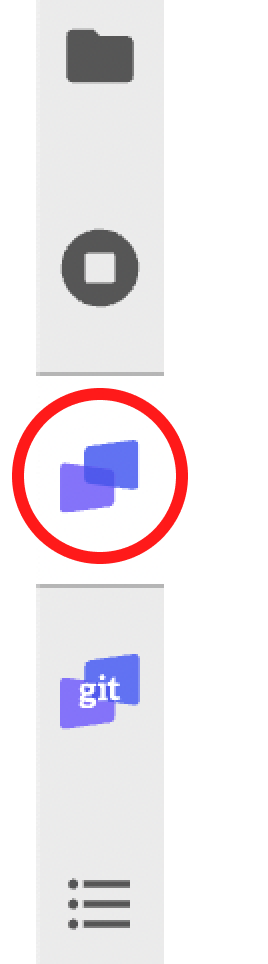
And below is an example of a classification model that predicts the type of flower from examples of petals. If you click Link tab to the left, you can notice that you can do everything all in the pipeline structures with Link. 
    
</div>
    
</div>

### **Load iris data**

In [ ]:
from sklearn.datasets import load_iris

data = load_iris()

### **Create dataframe**

In [ ]:
import numpy as np
import pandas as pd

df = pd.DataFrame(data["data"], columns=data["feature_names"])
df["target"] = data["target"]

### **Train/valid split**

In [ ]:
import numpy as np

train_ratio = 0.7
train_len = int(train_ratio * len(df))
indices = np.random.permutation(df.index)
train_indices = indices[:train_len]
valid_indices = indices[train_len:]

### **Create dataloaders**

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset

dataset = TensorDataset(torch.from_numpy(df.loc[:, data["feature_names"]].values).float(), torch.from_numpy(df.loc[:, "target"].values).long())
train_loader = DataLoader(Subset(dataset, train_indices), batch_size=20)
valid_loader = DataLoader(Subset(dataset, valid_indices), batch_size=len(valid_indices))

### **Define pl model**

In [ ]:
from typing import Union, Dict, List, Any
import torch
import torchmetrics
import pytorch_lightning as pl

class Classifier(pl.LightningModule):
    
    def __init__(self):
        super().__init__()

        self._metrics: Dict[str, Dict[str, Any]] = {
            "train": {
                "acc": torchmetrics.Accuracy(),
            },
            "valid": {
                "acc": torchmetrics.Accuracy(),
            },
        }
        seq = [
            torch.nn.Linear(4, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 8),
            torch.nn.ReLU(),
            torch.nn.Linear(8, 5),
            torch.nn.ReLU(),
            torch.nn.Linear(5, 3),
            torch.nn.Softmax(),
        ]
        self.fcn: torch.nn.Sequential = torch.nn.Sequential(*seq)

    def forward(self, x: torch.Tensor) -> Any:
        """
        Documentation.
        Parameters
        ----------
        x: torch.Tensor
        Returns
        -------
        Any
        """
        return self.fcn(x)

    def training_step(self, train_batch: torch.Tensor, batch_idx: int) -> Union[torch.Tensor, Dict[str, Any]]:
        batch_x, batch_y = train_batch
        batch_y_hat: torch.Tensor = self(batch_x)
        loss = torch.nn.CrossEntropyLoss()(batch_y_hat, batch_y)
        self.log("train_loss", loss, on_epoch=True)

        train_metrics: List[Dict[str, Any]] = self._metrics["train"]
        for name, metric in train_metrics.items():
            self.log("Train: {0}".format(name), metric(torch.argmax(batch_y_hat, dim=1), batch_y), on_epoch=True)
        return loss

    def validation_step(self, valid_batch: torch.Tensor, batch_idx: int) -> None:
        batch_x, batch_y = valid_batch

        batch_y_hat: torch.Tensor = self(batch_x)
        loss = torch.nn.CrossEntropyLoss()(batch_y_hat, batch_y)
        self.log("valid_loss", loss, on_epoch=True)
        for name, metric in self._metrics["valid"].items():
            self.log("Valid: {0}".format(name), metric(torch.argmax(batch_y_hat, dim=1), batch_y), on_epoch=True)

    def configure_optimizers(self) -> Any:
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

### **Create pl model**

In [ ]:
model = Classifier()

### **Define liveplot logger**

In [ ]:
import argparse
from typing import Any, Dict, Optional
from livelossplot import PlotLosses
from pytorch_lightning.loggers import LightningLoggerBase
from pytorch_lightning.loggers.base import rank_zero_experiment
from pytorch_lightning.utilities import rank_zero_only, types


class PlotLossesLogger(LightningLoggerBase):
    """Canvas Logger for lightning trainers
    Args:
        LightningLoggerBase ([type]): [description]
    """

    def __init__(self, experiment="tmp", max_epoch=None, **kwargs):
        super().__init__()
        self._plotlosses = PlotLosses(**kwargs).reset_outputs().to_matplotlib(max_epoch=max_epoch)
        self._experiment = experiment
        self._last_epoch = 0
        self._last_metrics = {}

    @property  # type: ignore
    @rank_zero_experiment
    def experiment(self) -> str:
        return self._experiment

    @rank_zero_only
    def log_hyperparams(self, params: argparse.Namespace, *args: Any, **kwargs: Any) -> None:
        pass

    @rank_zero_only
    def log_metrics(self, metrics: Dict[str, Any], step: Optional[int] = None) -> None:
        if metrics["epoch"] > self._last_epoch and "valid_loss" in metrics:
            # Update accumulated metrics
            if "train_loss_step" in self._last_metrics:
                self._last_metrics.pop("train_loss_step")
            self._plotlosses.update(self._last_metrics)
            self._plotlosses.send()
            self._last_epoch = metrics.pop("epoch")
            self._last_metrics = metrics
        else:
            metrics.pop("epoch")
            self._last_metrics = {**self._last_metrics, **metrics}

    @property
    def name(self) -> str:
        return "canvas"

    @property
    def version(self) -> str:
        return "prototype"

### **Train model**

In [ ]:
max_epoch = 10
logger = PlotLossesLogger(
    groups={"loss": ["train_loss_epoch", "valid_loss"], "Accuracy": ["Train: acc_epoch", "Valid: acc"]},
    max_epoch=max_epoch,
)
trainer = pl.Trainer(max_epochs=max_epoch, logger=[logger], enable_progress_bar=False)
trainer.fit(model, train_loader, valid_loader)